# T7 - Calibration

<div class="alert alert-info">
    
An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/starsimhub/starsim/blob/main/docs/tutorials/tut_calibration.ipynb?install=starsim) or [Binder](https://mybinder.org/v2/gh/starsimhub/starsim/HEAD?labpath=docs%2Ftutorials%2Ftut_calibration.ipynb).
    
</div>

Disease models typically require contextualization to a relevant setting of interest prior to addressing "what-if" scenario questions. The process of tuning model input parameters so that model outputs match observed data is known as calibration. There are many approaches to model calibration, ranging from manual tuning to fully Bayesian methods.

For many applications, we have found that an optimization-based approach is sufficient. Such methods avoid the tedious process of manual tuning and are less computationally expensive than fully Bayesian methods. One such optimization-based approach is the Optuna library, which is a Bayesian hyperparameter optimization framework. Optuna is designed for tuning hyperparameters of machine learning models, but it can also be used to calibrate disease models.

Calibration libraries often treat the disease model as a black box, where the input parameters are the "hyperparameters" to be tuned. The calibration process is often iterative and requires a combination of expert knowledge and computational tools. The optimization algorithm iteratively chooses new parameter values to evaluate, and the model is run with these values to generate outputs. The outputs are compared to observed data, and a loss function is calculated to quantify the difference between the model outputs and the observed data. The optimization algorithm then uses this loss function to update its search strategy and choose new parameter values to evaluate. This process continues until the algorithm converges to a set of parameter values that minimize the loss function.

While many optimization algorithms are available, Starsim has a built-in interface to the Optuna library, which we will demonstrate in this tutorial. We will use a simple Susceptible-Infected-Recovered (SIR) model as an example. We will tune three input parameters, the infectivity parameter, `beta`, the initial prevalence parameter, `init_prev`, and the Poisson-distributed degree distribution parameter, `n_contacts`. We will calibrate the model using a beta-binomial likelihood function so as to match prevalence at three distinct time points.

We begin with a few imports and default settings:

In [2]:
#%% Imports and settings
import sciris as sc
import starsim as ss
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

n_agents = 2e3
debug = False # If true, will run in serial

/Users/dklein/miniforge3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The calibration class will require a base `Sim` object. This `sim` will later be modified according to parameters selected by the optimization engine. The following function creates the base `Sim` object.

In [3]:
def make_sim():
    sir = ss.SIR(
        beta = ss.beta(0.075),
        init_prev = ss.bernoulli(0.02),
    )
    random = ss.RandomNet(n_contacts=ss.poisson(4))

    sim = ss.Sim(
        n_agents = n_agents,
        start = sc.date('2020-01-01'),
        stop = sc.date('2020-02-12'),
        dt = 1,
        unit = 'day',
        diseases = sir,
        networks = random,
        verbose = 0,
    )

    return sim

Now let's define the calibration parameters. These are the inputs that Optuna will be able to modify. Here, we define three such parameters, `beta`, `init_prev`, and `n_contacts`.

Each parameter entry should have range defined by `low` and `high` as well as a `guess` values. The `guess` value is not used by Optuna, rather only for a check after calibration completes to see if the new parameters are better than the `guess` values.

You'll notice there are a few other parameters that can be specified. For example, the data type of the parameter appears in `suggest_type`. Possible values are listed in the Optuna documentation, and include [suggest_float](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float) for float values and [suggest_int](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) for integer types.

To make things easier for the search algorithm, it's helpful to indicate how outputs are expected to change with inputs. For example, increasing `beta` from 0.01 to 0.02 should double disease transmission, but increasing from 0.11 to 0.12 will have a small effect. Thus, we indicate that this parameter should be calibrated with `log=True`.

In [4]:
# Define the calibration parameters
calib_pars = dict(
    beta = dict(low=0.01, high=0.30, guess=0.15, suggest_type='suggest_float', log=True), # Note the log scale
    init_prev = dict(low=0.01, high=0.05, guess=0.15), # Default type is suggest_float, no need to re-specify
    n_contacts = dict(low=2, high=10, guess=3, suggest_type='suggest_int'), # Suggest int just for this demo
)

The optimization engine iteratively chooses input parameters to simulate. Those parameters are passed into the following `build_sim` function as a dictionary of `calib_pars` along with the base `sim` and any other key word arguments. The `calib_pars` will be as above, but importantly will have an additional key named `value` containing the value selected by Optuna.

When modifying a `sim`, it is important to realize that the simulation has not been initialized yet. Nonetheless, the configuration is available for modification at `sim.pars`, as demonstrated in the function below for the SIR example.

In [5]:
def build_sim(sim, calib_pars, n_reps=1, **kwargs):
    """
    Modify the base simulation by applying calib_pars. The result can be a
    single simulation or multiple simulations if n_reps>1. Note that here we are
    simply building the simulation by modifying the base sim. Running the sims
    and extracting results will be done by the calibration function.
    """

    sir = sim.pars.diseases # There is only one disease in this simulation and it is a SIR
    net = sim.pars.networks # There is only one network in this simulation and it is a RandomNet

    for k, pars in calib_pars.items(): # Loop over the calibration parameters
        if k == 'rand_seed':
            sim.pars.rand_seed = v
            continue

        # Each item in calib_pars is a dictionary with keys like 'low', 'high',
        # 'guess', 'suggest_type', and importantly 'value'. The 'value' key is
        # the one we want to use as that's the one selected by the algorithm
        v = pars['value']
        if k == 'beta':
            sir.pars.beta = ss.beta(v)
        elif k == 'init_prev':
            sir.pars.init_prev = ss.bernoulli(v)
        elif k == 'n_contacts':
            net.pars.n_contacts = ss.poisson(v)
        else:
            raise NotImplementedError(f'Parameter {k} not recognized')

    # If just one simulation per parameter set, return the single simulation
    if n_reps == 1:
        return sim

    # But if you'd like to run multiple simulations with the same parameters, we return a MultiSim instead
    # Note that each simulation will have a different random seed, you can set specific seeds if you like
    # Also note that parallel=False and debug=True are important to avoid issues with parallelism in the calibration
    # Advanced: If running multiple reps, you can choose if/how they are combined using the "combine_reps" argument to each CalibComponent, introduced below.
    ms = ss.MultiSim(sim, iterpars=dict(rand_seed=np.random.randint(0, 1e6, n_reps)), initialize=True, debug=True, parallel=False)
    return ms

The Starsim framework has been integrated with the Optuna hyperparameter optimization algorithm to facilitate calibration through the `Calibration` class. Recall that an optimization-based approach to calibration minimizes a function of the input parameters. This function is key to achieving an acceptable calibration.

There are two ways to describe the goodness-of-fit function for the `Calibration`. The first method is to directly provide a function that the algorithm will call. The `eval_fn` will be passed each completed `sim` after running, and is expected to return a float representing the **mismatch (lower is better as the optimization algorithm is configured to minimize)**. Data can be passed into the `eval_fn` via `eval_kwargs`.

As an alternative to directly specifying the evaluation function, you can use `CalibComponent`s. Each component includes real data, for example from a survey, that is compared against simulation data from the model. Several components and be used at the same time, for example one for disease prevalence and another for treatment coverage. Each component computes a likelihood of the data given the input parameters, as assessed via simulation. Components are combined assuming independence.

The base class for a component is called `CalibComponent`, which you can use to define your own likelihood. However, we have provided components for several key likelihood functions including `BetaBinomial`, `Binomial`, `DirichletMultinomial`, `GammaPoisson`, and `Normal`. The `Normal` component is most like a traditional squared error. Each component takes in a `name` and a `weight`, which is used when combining log likelihoods.

Importantly, each component takes in the calibration target, the real data that was observed, in an argument called `expected`. This argument should be a Pandas Dataframe with one row per time point and columns that will depend on the specific component type. For example, the `Binomial` component requires columns of `n` (trials) and `x` (successes).

The components also handle extracting data from each simulation using the `extract_fn` argument. The value of this argument should be a function that takes in a simulation and returns a Pandas DataFrame. The specifics of the columns will depend a bit on the type of component (e.g. `BetaBinomial` is different from `Normal`), but often looks like a simulated version of `expected`. We will see examples below.

We'll also see how to use the `conform` argument, the purpose of which is to temporally align the simulation output to the real data. This argument works along with the `extract_fn` to produce the final simulation outputs that are used in the likelihood function. The conformer is a function that takes in the `expected` data you provided and the `actual` simulation result the comes out of the `extract_fn`. The conformers we have built in are as follows:
* `step_containing`: Conform by simply choosing the simulated timestep that contains the time indicated in the real data (`expected`)
* `prevalent`: Interpolate the simulated timepoints to estimate the values that would have occurred at each real timepoint
* `incident`: While the two methods above capture the state of the model at a particular point in time (stocks), this component allows you to capture the behavior of the model over time (flows). Instead of just giving one time value, `t`, you'll provide a second time value as well called `t1`. This conformer will add up events occurring between the two time points.

Let's make a Binomial component, as might be used to calibrate disease prevalence.

In [6]:
prevalence = ss.Normal(
    name = 'Disease prevalence',
    conform = 'prevalent',

    expected = pd.DataFrame({
        'x': [0.13, 0.16, 0.06],    # Prevalence of infection
    }, index=pd.Index([ss.date(d) for d in ['2020-01-12', '2020-01-25', '2020-02-02']], name='t')), # On these dates
    
    extract_fn = lambda sim: pd.DataFrame({
        'x': sim.results.sir.prevalence,
    }, index=pd.Index(sim.results.timevec, name='t')),

    # You can specify the variance as well, but it's optional (max likelihood estimates will be used if not provided)
    # This could be a single float or an array with the same shape as the expected values
    sigma2 = 0.05, # e.g. (num_replicates/sigma2_model + 1/sigma2_data)^-1
    #sigma2 = np.array([0.05, 0.25, 0.01])
)

Finally, we can bring all the pieces together. We make a single base simulation and create an instance of a Starsim Calibration object. This object requires a few arguments, like the `calib_pars` and `sim`. We also pass in the function that modifies the base `sim`, here our `build_sim` function. No additional `build_kw` are required in this example.

We also pass in a list of `components`. Instead of using this "component-based" system, a user could simply provide an `eval_fn`, which takes in a completed sim an any `eval_kwargs` and returns a "mismatch" score to be minimized.

We can also specify the total number of trials to run, the number of parallel works, and a few other parameters.

In [7]:
sc.heading('Beginning calibration')

# Make the sim and data
sim = make_sim()

# Make the calibration
calib = ss.Calibration(
    calib_pars = calib_pars,
    sim = sim,
    build_fn = build_sim,
    build_kw = dict(n_reps=3), # Run 3 replicates for each parameter set
    reseed = True, # If true, a different random seed will be provided to each configuration
    components = [prevalence],
    total_trials = 100,
    n_workers = None, # None indicates to use all available CPUs
    die = True,
    debug = debug, # Run in serial if True
)

# Perform the calibration
sc.printcyan('\nPeforming calibration...')
calib.calibrate();



—————————————————————
Beginning calibration
—————————————————————


Peforming calibration...
Removed existing calibration file starsim_calibration.db
sqlite:///starsim_calibration.db


[I 2024-12-20 16:19:03,231] A new study created in RDB with name: starsim_calibration


Elapsed time: 0.394 s
Elapsed time: 0.407 s
Elapsed time: 0.414 s


[I 2024-12-20 16:19:04,187] Trial 2 finished with value: -3.981469012110094 and parameters: {'beta': 0.037417244351436146, 'init_prev': 0.010024842663596743, 'n_contacts': 4, 'rand_seed': 206933}. Best is trial 2 with value: -3.981469012110094.
[I 2024-12-20 16:19:04,194] Trial 4 finished with value: -4.253477754007408 and parameters: {'beta': 0.25169207593339255, 'init_prev': 0.0369284447309977, 'n_contacts': 7, 'rand_seed': 99802}. Best is trial 4 with value: -4.253477754007408.


Elapsed time: 0.434 s
Elapsed time: 0.454 s
Elapsed time: 0.378 s
Elapsed time: 0.474 s


[I 2024-12-20 16:19:04,277] Trial 5 finished with value: -4.110218498708413 and parameters: {'beta': 0.017136100088927516, 'init_prev': 0.013074398734219388, 'n_contacts': 10, 'rand_seed': 487282}. Best is trial 4 with value: -4.253477754007408.
[I 2024-12-20 16:19:04,275] Trial 0 finished with value: -0.33079731967612536 and parameters: {'beta': 0.09192459562761521, 'init_prev': 0.034962506583021837, 'n_contacts': 8, 'rand_seed': 288667}. Best is trial 4 with value: -4.253477754007408.
[I 2024-12-20 16:19:04,285] Trial 6 finished with value: -4.96346792087361 and parameters: {'beta': 0.033034929855499606, 'init_prev': 0.030087148862981306, 'n_contacts': 7, 'rand_seed': 857250}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.428 s


[I 2024-12-20 16:19:04,316] Trial 7 finished with value: -4.314967831788729 and parameters: {'beta': 0.01704651299601035, 'init_prev': 0.036653855162567896, 'n_contacts': 10, 'rand_seed': 14229}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.430 s
Elapsed time: 0.400 s


[I 2024-12-20 16:19:04,332] Trial 8 finished with value: -2.967393958142111 and parameters: {'beta': 0.05608643768869503, 'init_prev': 0.04211205878958777, 'n_contacts': 7, 'rand_seed': 184047}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:04,359] Trial 9 finished with value: -1.3351021806588834 and parameters: {'beta': 0.1630078741814786, 'init_prev': 0.03776827756073549, 'n_contacts': 5, 'rand_seed': 615047}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:04,376] Trial 3 finished with value: -4.272857389293877 and parameters: {'beta': 0.214360825304862, 'init_prev': 0.030194488038575364, 'n_contacts': 8, 'rand_seed': 756904}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:04,378] Trial 1 finished with value: -4.307473004811523 and parameters: {'beta': 0.018732667334945705, 'init_prev': 0.018144159097947726, 'n_contacts': 10, 'rand_seed': 927857}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.308 s
Elapsed time: 0.281 s


[I 2024-12-20 16:19:04,620] Trial 10 finished with value: 0.27488850768987305 and parameters: {'beta': 0.10721394879165765, 'init_prev': 0.042976924214614104, 'n_contacts': 5, 'rand_seed': 999285}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:04,626] Trial 11 finished with value: -4.568153268215385 and parameters: {'beta': 0.05548301002832378, 'init_prev': 0.011385314341003495, 'n_contacts': 4, 'rand_seed': 336052}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.278 s
Elapsed time: 0.299 s


[I 2024-12-20 16:19:04,669] Trial 12 finished with value: -3.4280658616849786 and parameters: {'beta': 0.2778960384459443, 'init_prev': 0.01658346602772259, 'n_contacts': 5, 'rand_seed': 609505}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:04,670] Trial 13 finished with value: -0.5120752133053845 and parameters: {'beta': 0.055420810636232214, 'init_prev': 0.04614009450868435, 'n_contacts': 9, 'rand_seed': 385994}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.334 s
Elapsed time: 0.279 s
Elapsed time: 0.270 s

[I 2024-12-20 16:19:04,746] Trial 14 finished with value: -4.191952086513177 and parameters: {'beta': 0.015476294899596331, 'init_prev': 0.031271529312769934, 'n_contacts': 10, 'rand_seed': 233088}. Best is trial 6 with value: -4.96346792087361.


[I 2024-12-20 16:19:04,757] Trial 17 finished with value: -3.9287303423637017 and parameters: {'beta': 0.03537823196780626, 'init_prev': 0.023991007676089308, 'n_contacts': 3, 'rand_seed': 978399}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.329 s


[I 2024-12-20 16:19:04,790] Trial 19 finished with value: -3.847880373068212 and parameters: {'beta': 0.010121343508262142, 'init_prev': 0.049164845647649086, 'n_contacts': 3, 'rand_seed': 965682}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.283 s
Elapsed time: 0.280 s


[I 2024-12-20 16:19:04,811] Trial 15 finished with value: -1.8150176990728721 and parameters: {'beta': 0.04196959939549502, 'init_prev': 0.048523722299440186, 'n_contacts': 10, 'rand_seed': 220812}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:04,826] Trial 16 finished with value: -3.931741309631425 and parameters: {'beta': 0.037302784800072084, 'init_prev': 0.04920009989764053, 'n_contacts': 2, 'rand_seed': 959354}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:04,840] Trial 18 finished with value: -3.9041105357484094 and parameters: {'beta': 0.035135221889772146, 'init_prev': 0.04990946659850351, 'n_contacts': 2, 'rand_seed': 999365}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.254 s


[I 2024-12-20 16:19:04,993] Trial 20 finished with value: -3.8783381662081737 and parameters: {'beta': 0.03743268510290505, 'init_prev': 0.022141646264920357, 'n_contacts': 2, 'rand_seed': 402145}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.262 s
Elapsed time: 0.247 s
Elapsed time: 0.241 s


[I 2024-12-20 16:19:05,020] Trial 21 finished with value: -3.91939383090301 and parameters: {'beta': 0.03576781434233085, 'init_prev': 0.0210273735090926, 'n_contacts': 3, 'rand_seed': 454075}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:05,034] Trial 23 finished with value: -3.851635932150905 and parameters: {'beta': 0.031470300613332725, 'init_prev': 0.0249087470755512, 'n_contacts': 2, 'rand_seed': 800405}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:05,034] Trial 22 finished with value: -3.8642150477734125 and parameters: {'beta': 0.02822364779154515, 'init_prev': 0.024343359425285017, 'n_contacts': 2, 'rand_seed': 795422}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.264 s


[I 2024-12-20 16:19:05,122] Trial 24 finished with value: -3.832533432150904 and parameters: {'beta': 0.010308223404289241, 'init_prev': 0.024712174756634092, 'n_contacts': 2, 'rand_seed': 715388}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.266 s


[I 2024-12-20 16:19:05,158] Trial 25 finished with value: -3.841550421880136 and parameters: {'beta': 0.010013992407239757, 'init_prev': 0.023738767700687155, 'n_contacts': 3, 'rand_seed': 769450}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.256 sElapsed time: 0.304 s



[I 2024-12-20 16:19:05,225] Trial 26 finished with value: -3.8583561233802106 and parameters: {'beta': 0.02690348329736941, 'init_prev': 0.023082308474859578, 'n_contacts': 2, 'rand_seed': 797226}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:05,226] Trial 27 finished with value: -0.5102162847173399 and parameters: {'beta': 0.08018801186730656, 'init_prev': 0.024873323929585033, 'n_contacts': 6, 'rand_seed': 736164}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.299 s
Elapsed time: 0.315 s


[I 2024-12-20 16:19:05,268] Trial 29 finished with value: 0.5723367527120626 and parameters: {'beta': 0.08774012102700278, 'init_prev': 0.02348237493257961, 'n_contacts': 6, 'rand_seed': 797475}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:05,277] Trial 28 finished with value: 0.23796139725881638 and parameters: {'beta': 0.08544749595245886, 'init_prev': 0.024329846787536732, 'n_contacts': 6, 'rand_seed': 810186}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.326 s


[I 2024-12-20 16:19:05,408] Trial 30 finished with value: -4.310009393247827 and parameters: {'beta': 0.024119395514576522, 'init_prev': 0.025415741587549476, 'n_contacts': 7, 'rand_seed': 2042}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.296 s
Elapsed time: 0.295 s


[I 2024-12-20 16:19:05,451] Trial 31 finished with value: -4.069917335782601 and parameters: {'beta': 0.023201267322547705, 'init_prev': 0.032758997140081944, 'n_contacts': 6, 'rand_seed': 14101}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:05,470] Trial 32 finished with value: -4.031734315206253 and parameters: {'beta': 0.022645131641027164, 'init_prev': 0.03269093538069534, 'n_contacts': 6, 'rand_seed': 71370}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.317 s


[I 2024-12-20 16:19:05,493] Trial 33 finished with value: -0.18477637592379348 and parameters: {'beta': 0.08406052835296553, 'init_prev': 0.03412693636437504, 'n_contacts': 6, 'rand_seed': 35547}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.305 s


[I 2024-12-20 16:19:05,534] Trial 34 finished with value: -4.125066245796249 and parameters: {'beta': 0.023361835443615243, 'init_prev': 0.032848289082890295, 'n_contacts': 6, 'rand_seed': 1616}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.304 s


[I 2024-12-20 16:19:05,575] Trial 35 finished with value: -4.047727824709064 and parameters: {'beta': 0.0224967399968529, 'init_prev': 0.03380750048116253, 'n_contacts': 6, 'rand_seed': 17057}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.298 s
Elapsed time: 0.302 s


[I 2024-12-20 16:19:05,628] Trial 37 finished with value: -3.98023391416974 and parameters: {'beta': 0.02126232417347767, 'init_prev': 0.03228035629398822, 'n_contacts': 6, 'rand_seed': 20245}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:05,646] Trial 36 finished with value: -4.149530954727393 and parameters: {'beta': 0.023373744513313054, 'init_prev': 0.0333701020767417, 'n_contacts': 6, 'rand_seed': 81742}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.332 s
Elapsed time: 0.326 s


[I 2024-12-20 16:19:05,712] Trial 38 finished with value: -4.731832036958772 and parameters: {'beta': 0.022083391724363487, 'init_prev': 0.03330538449448065, 'n_contacts': 9, 'rand_seed': 21525}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:05,718] Trial 39 finished with value: -4.403708070764546 and parameters: {'beta': 0.01983844542229209, 'init_prev': 0.03370411520995762, 'n_contacts': 9, 'rand_seed': 41336}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.312 s


[I 2024-12-20 16:19:05,814] Trial 40 finished with value: -4.3807073007018165 and parameters: {'beta': 0.021357562231367085, 'init_prev': 0.03385508081030296, 'n_contacts': 8, 'rand_seed': 18267}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.336 s
Elapsed time: 0.295 s


[I 2024-12-20 16:19:05,881] Trial 41 finished with value: -4.4257642737329865 and parameters: {'beta': 0.021911873113114037, 'init_prev': 0.028372217132232404, 'n_contacts': 8, 'rand_seed': 3525}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:05,887] Trial 43 finished with value: -3.912669194670734 and parameters: {'beta': 0.012653914862052765, 'init_prev': 0.028056630932591156, 'n_contacts': 8, 'rand_seed': 319665}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.314 s
Elapsed time: 0.310 s

[I 2024-12-20 16:19:05,934] Trial 42 finished with value: -3.9548939052039502 and parameters: {'beta': 0.01290370142480792, 'init_prev': 0.03903685876520275, 'n_contacts': 8, 'rand_seed': 137858}. Best is trial 6 with value: -4.96346792087361.


[I 2024-12-20 16:19:05,952] Trial 44 finished with value: -3.979185034517922 and parameters: {'beta': 0.013750441852443042, 'init_prev': 0.03679913775359725, 'n_contacts': 8, 'rand_seed': 139808}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.312 s


[I 2024-12-20 16:19:06,010] Trial 45 finished with value: -3.9446964644270963 and parameters: {'beta': 0.013223205395926694, 'init_prev': 0.027199262217605713, 'n_contacts': 8, 'rand_seed': 142829}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.317 s


[I 2024-12-20 16:19:06,073] Trial 46 finished with value: -3.999818318710452 and parameters: {'beta': 0.013608635532037998, 'init_prev': 0.0282190807645481, 'n_contacts': 8, 'rand_seed': 153091}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.320 s


[I 2024-12-20 16:19:06,106] Trial 47 finished with value: -3.5836443654293912 and parameters: {'beta': 0.0476019028630821, 'init_prev': 0.027931363621646894, 'n_contacts': 8, 'rand_seed': 151069}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.311 s
Elapsed time: 0.331 s


[I 2024-12-20 16:19:06,138] Trial 49 finished with value: -4.065858734810922 and parameters: {'beta': 0.014705288407808548, 'init_prev': 0.028840404975220044, 'n_contacts': 9, 'rand_seed': 153257}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:06,171] Trial 48 finished with value: -0.8874007385048959 and parameters: {'beta': 0.051899225414455595, 'init_prev': 0.02809452767056926, 'n_contacts': 9, 'rand_seed': 143471}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.322 s


[I 2024-12-20 16:19:06,247] Trial 50 finished with value: -4.009981773864236 and parameters: {'beta': 0.014531731230022283, 'init_prev': 0.028017307459788327, 'n_contacts': 8, 'rand_seed': 151245}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.317 s
Elapsed time: 0.327 s


[I 2024-12-20 16:19:06,311] Trial 51 finished with value: -4.042903602185734 and parameters: {'beta': 0.014705871897601435, 'init_prev': 0.028510532371183332, 'n_contacts': 9, 'rand_seed': 156937}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:06,324] Trial 52 finished with value: -4.047555598742092 and parameters: {'beta': 0.014344343484840847, 'init_prev': 0.0283132287428788, 'n_contacts': 9, 'rand_seed': 143239}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.338 s


[I 2024-12-20 16:19:06,388] Trial 53 finished with value: -1.9509276273833693 and parameters: {'beta': 0.048718896307320216, 'init_prev': 0.028473781962211474, 'n_contacts': 9, 'rand_seed': 295694}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.380 s


[I 2024-12-20 16:19:06,443] Trial 54 finished with value: -2.6301674291008625 and parameters: {'beta': 0.04664270121244818, 'init_prev': 0.02829354748447327, 'n_contacts': 9, 'rand_seed': 283286}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.354 s
Elapsed time: 0.329 s


[I 2024-12-20 16:19:06,493] Trial 55 finished with value: -3.734891465005996 and parameters: {'beta': 0.048119314691455195, 'init_prev': 0.013301829407889484, 'n_contacts': 9, 'rand_seed': 302974}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:06,506] Trial 56 finished with value: -4.852433175624525 and parameters: {'beta': 0.0464066558946897, 'init_prev': 0.010356682780422635, 'n_contacts': 9, 'rand_seed': 569030}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.335 s


[I 2024-12-20 16:19:06,555] Trial 57 finished with value: -3.9729993328595015 and parameters: {'beta': 0.018580441577404152, 'init_prev': 0.01166730685394879, 'n_contacts': 9, 'rand_seed': 294062}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.331 s
Elapsed time: 0.322 s


[I 2024-12-20 16:19:06,605] Trial 58 finished with value: -1.9312143990806354 and parameters: {'beta': 0.06093173057119459, 'init_prev': 0.03998853268462139, 'n_contacts': 7, 'rand_seed': 283579}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:06,625] Trial 59 finished with value: -3.897907385151667 and parameters: {'beta': 0.01832751670705425, 'init_prev': 0.010138456709412852, 'n_contacts': 7, 'rand_seed': 266808}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.313 s


[I 2024-12-20 16:19:06,686] Trial 60 finished with value: -3.9178109321509043 and parameters: {'beta': 0.016882126981979, 'init_prev': 0.011120575057322049, 'n_contacts': 7, 'rand_seed': 250431}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.302 s


[I 2024-12-20 16:19:06,719] Trial 61 finished with value: -2.3459363198775436 and parameters: {'beta': 0.07292899982280997, 'init_prev': 0.010505013563906342, 'n_contacts': 7, 'rand_seed': 251037}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.310 s


[I 2024-12-20 16:19:06,777] Trial 62 finished with value: -2.60800706872282 and parameters: {'beta': 0.06986565732289143, 'init_prev': 0.01092518560223996, 'n_contacts': 7, 'rand_seed': 264728}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.329 s


[I 2024-12-20 16:19:06,837] Trial 63 finished with value: -3.9190865283963756 and parameters: {'beta': 0.018431348835862674, 'init_prev': 0.012288715678516176, 'n_contacts': 7, 'rand_seed': 604409}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.320 s


[I 2024-12-20 16:19:06,887] Trial 64 finished with value: -3.9576359708283224 and parameters: {'beta': 0.01950370647588393, 'init_prev': 0.010337116799853757, 'n_contacts': 7, 'rand_seed': 550896}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.327 s


[I 2024-12-20 16:19:06,941] Trial 65 finished with value: -1.736699164207939 and parameters: {'beta': 0.06794293523267542, 'init_prev': 0.012122729341391065, 'n_contacts': 7, 'rand_seed': 606770}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.310 sElapsed time: 0.346 s



[I 2024-12-20 16:19:06,987] Trial 67 finished with value: -1.8737319558789611 and parameters: {'beta': 0.06819421157099319, 'init_prev': 0.018510574454367778, 'n_contacts': 7, 'rand_seed': 680093}. Best is trial 6 with value: -4.96346792087361.
[I 2024-12-20 16:19:07,001] Trial 66 finished with value: -4.182216784167397 and parameters: {'beta': 0.070177524486657, 'init_prev': 0.010250983922459248, 'n_contacts': 7, 'rand_seed': 595667}. Best is trial 6 with value: -4.96346792087361.


Elapsed time: 0.326 sElapsed time: 0.299 s



[I 2024-12-20 16:19:07,059] Trial 68 finished with value: 2.6283942496582293 and parameters: {'beta': 0.06187823735038966, 'init_prev': 0.01778640908913256, 'n_contacts': 10, 'rand_seed': 549365}. Best is trial 69 with value: -5.101512117599782.
[I 2024-12-20 16:19:07,061] Trial 69 finished with value: -5.101512117599782 and parameters: {'beta': 0.06375730184539392, 'init_prev': 0.01612216208831746, 'n_contacts': 5, 'rand_seed': 563193}. Best is trial 69 with value: -5.101512117599782.


Elapsed time: 0.311 s


[I 2024-12-20 16:19:07,118] Trial 70 finished with value: 4.158536220472281 and parameters: {'beta': 0.06989985923683656, 'init_prev': 0.016095968835332323, 'n_contacts': 10, 'rand_seed': 572223}. Best is trial 69 with value: -5.101512117599782.


Elapsed time: 0.327 s


[I 2024-12-20 16:19:07,175] Trial 71 finished with value: -4.9601583845303026 and parameters: {'beta': 0.02946686955461743, 'init_prev': 0.03539115197534534, 'n_contacts': 10, 'rand_seed': 574928}. Best is trial 69 with value: -5.101512117599782.


Elapsed time: 0.331 s


[I 2024-12-20 16:19:07,204] Trial 72 finished with value: -5.068409846425914 and parameters: {'beta': 0.027428533482537577, 'init_prev': 0.030714287129912345, 'n_contacts': 10, 'rand_seed': 637204}. Best is trial 69 with value: -5.101512117599782.


Elapsed time: 0.355 s
Elapsed time: 0.324 s


[I 2024-12-20 16:19:07,319] Trial 73 finished with value: -4.551771647664145 and parameters: {'beta': 0.030578191635755623, 'init_prev': 0.03532915167749689, 'n_contacts': 10, 'rand_seed': 572134}. Best is trial 69 with value: -5.101512117599782.
[I 2024-12-20 16:19:07,320] Trial 74 finished with value: -5.059638638741414 and parameters: {'beta': 0.029182348958440015, 'init_prev': 0.03550113700886512, 'n_contacts': 10, 'rand_seed': 57196}. Best is trial 69 with value: -5.101512117599782.


Elapsed time: 0.355 s
Elapsed time: 0.305 s


[I 2024-12-20 16:19:07,413] Trial 75 finished with value: -5.1912933928377045 and parameters: {'beta': 0.030218786992333626, 'init_prev': 0.015619928857184428, 'n_contacts': 10, 'rand_seed': 860190}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.334 s


[I 2024-12-20 16:19:07,426] Trial 77 finished with value: -3.3254906470876255 and parameters: {'beta': 0.10570319040155794, 'init_prev': 0.0355484637358812, 'n_contacts': 10, 'rand_seed': 62384}. Best is trial 75 with value: -5.1912933928377045.
[I 2024-12-20 16:19:07,456] Trial 76 finished with value: -4.759231347351309 and parameters: {'beta': 0.03237286572726638, 'init_prev': 0.03530337258538205, 'n_contacts': 10, 'rand_seed': 914353}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.305 s
Elapsed time: 0.326 s


[I 2024-12-20 16:19:07,503] Trial 78 finished with value: -1.311896118756609 and parameters: {'beta': 0.12455165825858763, 'init_prev': 0.014102804633267052, 'n_contacts': 4, 'rand_seed': 890822}. Best is trial 75 with value: -5.1912933928377045.
[I 2024-12-20 16:19:07,512] Trial 79 finished with value: -4.155283046725712 and parameters: {'beta': 0.02945442264238877, 'init_prev': 0.030474546305845597, 'n_contacts': 5, 'rand_seed': 895436}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.308 s


[I 2024-12-20 16:19:07,563] Trial 80 finished with value: 2.727470618543632 and parameters: {'beta': 0.11932976572769576, 'init_prev': 0.01332628246136136, 'n_contacts': 5, 'rand_seed': 61505}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.309 s


[I 2024-12-20 16:19:07,622] Trial 81 finished with value: -3.982980082950284 and parameters: {'beta': 0.0316664223377514, 'init_prev': 0.03021503158952814, 'n_contacts': 4, 'rand_seed': 878406}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.333 s


[I 2024-12-20 16:19:07,685] Trial 82 finished with value: -1.9881136737443048 and parameters: {'beta': 0.10751783357295944, 'init_prev': 0.03102394763512968, 'n_contacts': 4, 'rand_seed': 874033}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.311 s
Elapsed time: 0.308 s


[I 2024-12-20 16:19:07,726] Trial 83 finished with value: -4.0055330035015455 and parameters: {'beta': 0.03168570387158512, 'init_prev': 0.030547024020967876, 'n_contacts': 4, 'rand_seed': 863305}. Best is trial 75 with value: -5.1912933928377045.
[I 2024-12-20 16:19:07,749] Trial 84 finished with value: -4.421869433843476 and parameters: {'beta': 0.04279824507336413, 'init_prev': 0.030318436285062728, 'n_contacts': 4, 'rand_seed': 857100}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.320 s
Elapsed time: 0.297 s


[I 2024-12-20 16:19:07,869] Trial 85 finished with value: -4.698636768975232 and parameters: {'beta': 0.040127020272905385, 'init_prev': 0.030620999747941042, 'n_contacts': 5, 'rand_seed': 880311}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.331 s

[I 2024-12-20 16:19:07,880] Trial 87 finished with value: -4.191635936579667 and parameters: {'beta': 0.03948619450706928, 'init_prev': 0.031005497959293287, 'n_contacts': 4, 'rand_seed': 891178}. Best is trial 75 with value: -5.1912933928377045.


[I 2024-12-20 16:19:07,904] Trial 86 finished with value: -4.283036613282253 and parameters: {'beta': 0.040134651379341295, 'init_prev': 0.03082199874963355, 'n_contacts': 4, 'rand_seed': 895830}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.348 s
Elapsed time: 0.347 s


[I 2024-12-20 16:19:07,969] Trial 88 finished with value: -2.010664916120321 and parameters: {'beta': 0.04147311938470579, 'init_prev': 0.03812170942172549, 'n_contacts': 10, 'rand_seed': 653746}. Best is trial 75 with value: -5.1912933928377045.
[I 2024-12-20 16:19:07,992] Trial 89 finished with value: -2.3583346931320404 and parameters: {'beta': 0.03963000969080778, 'init_prev': 0.038251544464086525, 'n_contacts': 10, 'rand_seed': 651985}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.330 s


[I 2024-12-20 16:19:08,063] Trial 90 finished with value: -5.080081204192949 and parameters: {'beta': 0.026251946626103532, 'init_prev': 0.031731862080314005, 'n_contacts': 10, 'rand_seed': 658030}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.354 s


[I 2024-12-20 16:19:08,090] Trial 91 finished with value: -2.2610107484890363 and parameters: {'beta': 0.04074648646010614, 'init_prev': 0.038486546583682904, 'n_contacts': 10, 'rand_seed': 648221}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.360 s


[I 2024-12-20 16:19:08,161] Trial 92 finished with value: -2.4142327986420327 and parameters: {'beta': 0.04101519917653476, 'init_prev': 0.03853205508853952, 'n_contacts': 10, 'rand_seed': 661595}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.358 s


[I 2024-12-20 16:19:08,195] Trial 93 finished with value: -5.099244183710425 and parameters: {'beta': 0.026420511458047725, 'init_prev': 0.037999317573847655, 'n_contacts': 10, 'rand_seed': 488454}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.372 s


[I 2024-12-20 16:19:08,248] Trial 94 finished with value: -4.906253937871691 and parameters: {'beta': 0.026261479311567717, 'init_prev': 0.03734064738075927, 'n_contacts': 10, 'rand_seed': 660193}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.352 s


[I 2024-12-20 16:19:08,319] Trial 95 finished with value: -4.985382303513 and parameters: {'beta': 0.02484316878475621, 'init_prev': 0.038751751512411683, 'n_contacts': 10, 'rand_seed': 484015}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.330 s


[I 2024-12-20 16:19:08,344] Trial 97 finished with value: -4.984403967687139 and parameters: {'beta': 0.02675776606919069, 'init_prev': 0.038766069170962085, 'n_contacts': 10, 'rand_seed': 666010}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.313 s


[I 2024-12-20 16:19:08,361] Trial 96 finished with value: -5.050181420239609 and parameters: {'beta': 0.026360541941796805, 'init_prev': 0.03782934830556685, 'n_contacts': 10, 'rand_seed': 658997}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.303 s


[I 2024-12-20 16:19:08,402] Trial 98 finished with value: -5.1201705978716205 and parameters: {'beta': 0.026686688767962274, 'init_prev': 0.020572026308983374, 'n_contacts': 10, 'rand_seed': 472059}. Best is trial 75 with value: -5.1912933928377045.


Elapsed time: 0.291 s


[I 2024-12-20 16:19:08,424] Trial 99 finished with value: -4.08285043819595 and parameters: {'beta': 0.03498719586630756, 'init_prev': 0.036102563351100014, 'n_contacts': 10, 'rand_seed': 508606}. Best is trial 75 with value: -5.1912933928377045.


Making results structure...
Processed 100 trials; 0 failed
Best pars: {'beta': 0.030218786992333626, 'init_prev': 0.015619928857184428, 'n_contacts': 10, 'rand_seed': 860190}
Removed existing calibration file starsim_calibration.db


Let's look at the best parameters that were found. Note that the `rand_seed` was selected at random, but the other parameters are meaningful.

In [8]:
calib.best_pars

{'beta': 0.030218786992333626,
 'init_prev': 0.015619928857184428,
 'n_contacts': 10,
 'rand_seed': 860190}

Once the calibration is complete, we can compare the `guess` values to the best values found by calling `check_fit`.

In [9]:
# Confirm - Note the comparison is here configured over n_reps=15 replicates
sc.printcyan('\nConfirming fit...')

# Increase replicates to 15 for more representative results when running check_fit
calib.build_kw['n_reps'] = 15

calib.check_fit(do_plot=False)


Confirming fit...

Checking fit...
Elapsed time: 0.542 s
Fit with original pars: -17.993060836337232
Fit with best-fit pars: -25.74032919704348
✓ Calibration improved fit -17.993060836337232 --> -25.74032919704348


True

After calling `check_fit`, we can plot the results. This first plot shows the Normal likelihood distributions from each of the 15 simulations we did in `check_fit` as the colored lines. The vertical dashed line is located at the real (`expected`) data. Top row is the "guess" values and the bottom row is the new "best" parameters. We want the vertical dashed line to cross the Gaussians at high points, representing high likelihood.

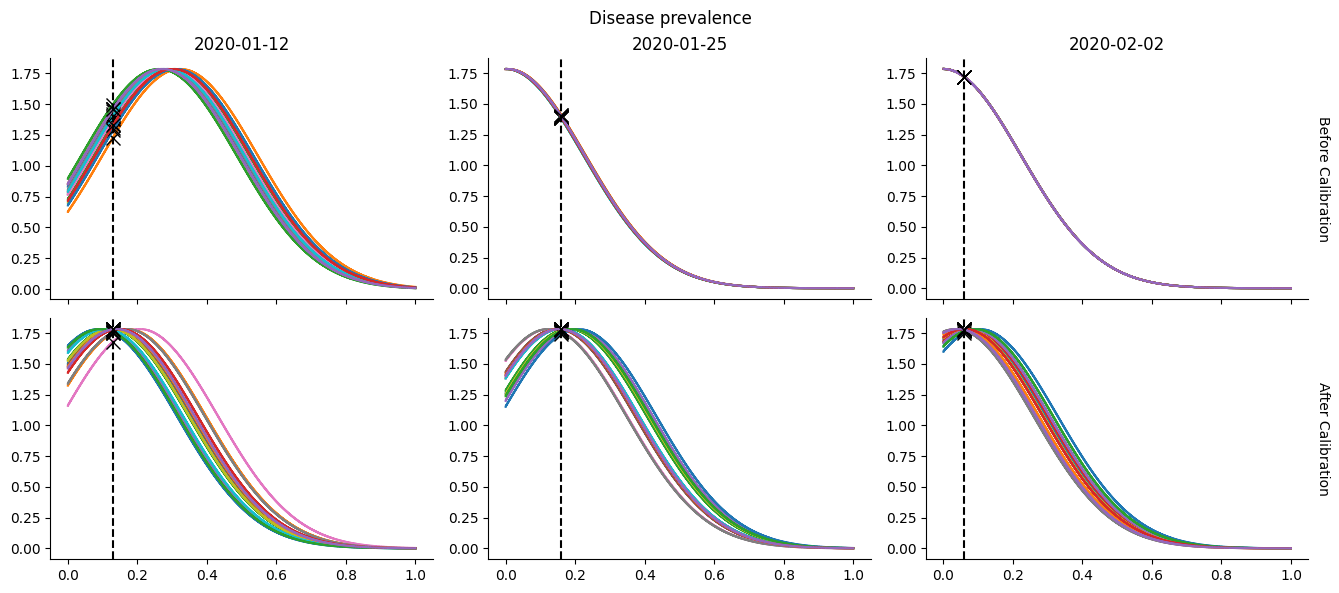

In [10]:
calib.plot();

Another way to plot the results is via bootstrapping. Here we repeatedly choose 15 from the `n_reps=15` simulations (with replacement), compute the average (or sum for some components), and repeatedly calculate the mean. We then plot the distribution of means, and hope it lands near the vertical dashed lines representing the real data.

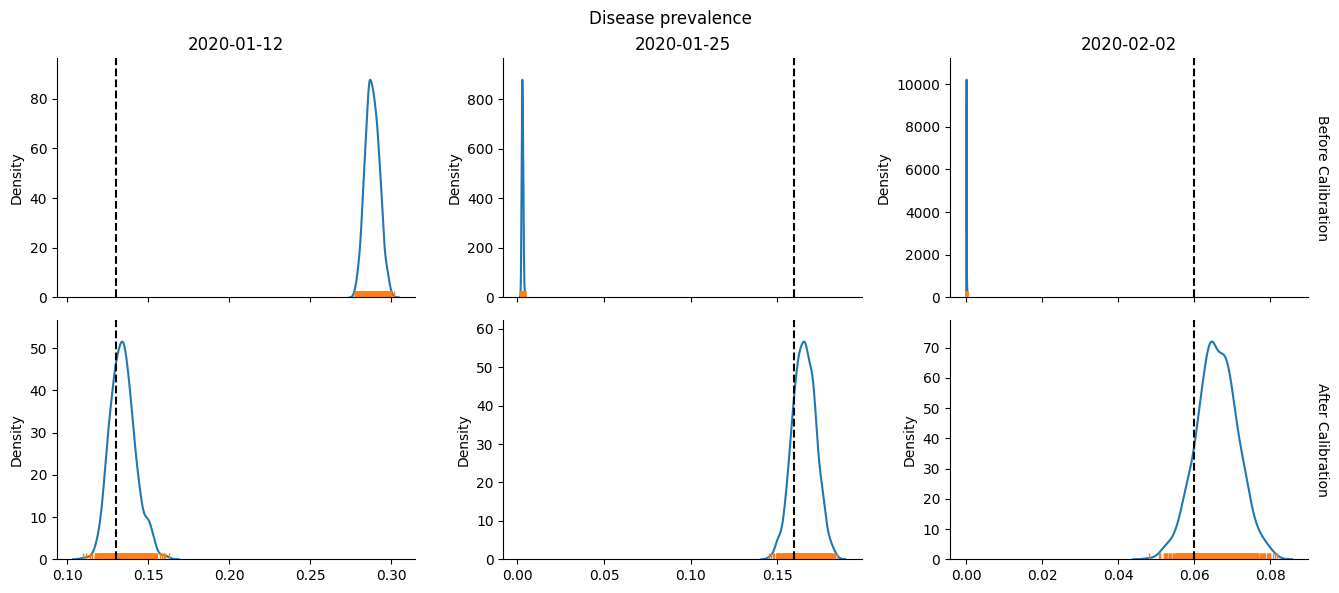

In [11]:
calib.plot(bootstrap=True); # Pass bootstrap=True to produce this plot

We can view some plots of the final fitted results. Whereas the two plots above were from the `check_fit`, running both "guess" and "best" parameters, here we make make new simulations to visualize the results.

Elapsed time: 1.41 s


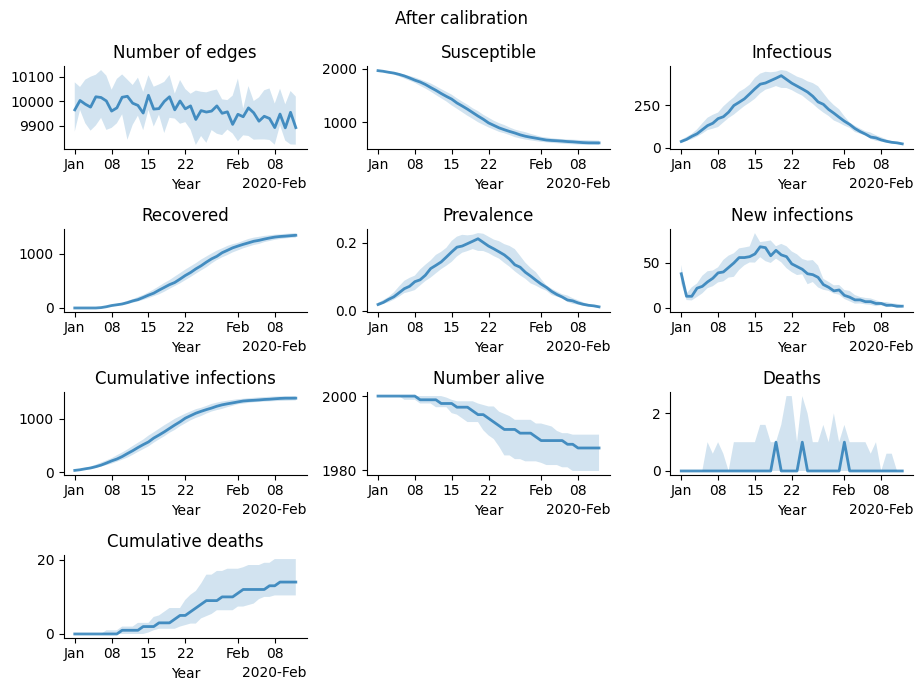

In [12]:
g = calib.plot_final(); # Run the model for 10 replicates
for ax in g.axes: # Fix the date formatting
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

Optuna has lots of diagnostic plots that we can explore. Possible plots include:
* plot_contour
* plot_edf
* plot_hypervolume_history
* plot_intermediate_values
* plot_optimization_history
* plot_parallel_coordinate
* plot_param_importances
* plot_pareto_front
* plot_rank
* plot_slice
* plot_terminator_improvement
* plot_timeline

Here are some examples:

/Users/dklein/GIT/starsim/starsim/calibration.py:435: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)


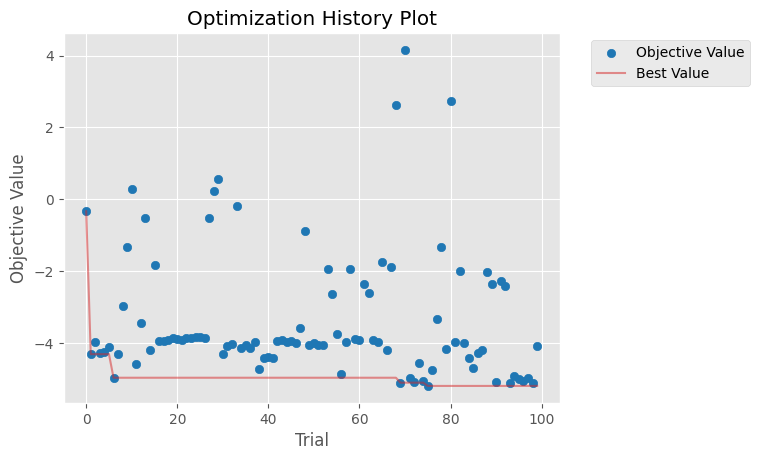

In [13]:
calib.plot_optuna('plot_optimization_history'); # Plot the optimization history

/Users/dklein/GIT/starsim/starsim/calibration.py:435: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)
[W 2024-12-20 16:19:17,962] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


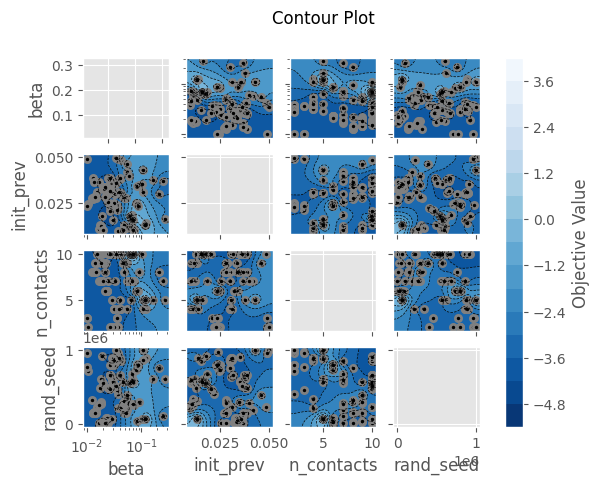

In [14]:
calib.plot_optuna('plot_contour');

/Users/dklein/GIT/starsim/starsim/calibration.py:435: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)


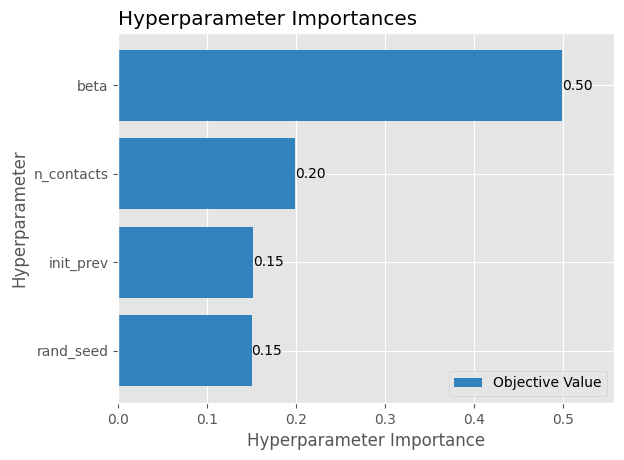

In [15]:
calib.plot_optuna('plot_param_importances');

If you choose not to use components, you can always create your own mismatch function, as in the following example:

In [ ]:
my_data = (ss.date('2020-01-12'), 0.13)

def eval(sim, expected):
    # Compute the squared error at one point in time.
    # expected will contain my_data in this example due to eval_kw
    date, p = expected
    if not isinstance(sim, ss.MultiSim):
        sim = ss.MultiSim(sims=[sim])

    ret = 0
    for s in sim.sims:
        ind = np.searchsorted(s.results.timevec, date, side='left')
        prev = s.results.sir.prevalence[ind]
        ret += (prev - p)**2
    return ret


# Define the calibration parameters
calib_pars = dict(
    beta = dict(low=0.01, high=0.30, guess=0.15, suggest_type='suggest_float', log=True),
)

# Make the sim and data
sim = make_sim()

# Make the calibration
calib = ss.Calibration(
    calib_pars = calib_pars,
    sim = sim,
    build_fn = build_sim,
    build_kw = dict(n_reps=2), # Two reps per point
    reseed = True,
    eval_fn = eval, # Will call my_function(msim, eval_kwargs)
    eval_kw = dict(expected=my_data), # Will call eval(sim, **eval_kw)
    total_trials = 10,
    n_workers = None, # None indicates to use all available CPUs
    die = True,
    debug = debug,
)

# Perform the calibration
sc.printcyan('\nPeforming calibration...')
calib.calibrate()

# Check
calib.check_fit()

[I 2024-12-20 16:20:08,317] A new study created in RDB with name: starsim_calibration



Peforming calibration...
Removed existing calibration file starsim_calibration.db
sqlite:///starsim_calibration.db
Elapsed time: 0.200 s
Elapsed time: 0.212 s

[I 2024-12-20 16:20:08,729] Trial 0 finished with value: 0.02004596568540512 and parameters: {'beta': 0.09074954599585874, 'rand_seed': 108575}. Best is trial 0 with value: 0.02004596568540512.



Elapsed time: 0.222 s


[I 2024-12-20 16:20:08,763] Trial 2 finished with value: 0.028322799424724873 and parameters: {'beta': 0.026002850390780343, 'rand_seed': 304908}. Best is trial 0 with value: 0.02004596568540512.


Elapsed time: 0.224 sElapsed time: 0.232 s


[I 2024-12-20 16:20:08,776] Trial 4 finished with value: 0.2544813520549364 and parameters: {'beta': 0.2571174368928315, 'rand_seed': 970479}. Best is trial 0 with value: 0.02004596568540512.



Elapsed time: 0.217 s


[I 2024-12-20 16:20:08,794] Trial 5 finished with value: 0.18312164395817565 and parameters: {'beta': 0.1142909338207521, 'rand_seed': 822910}. Best is trial 0 with value: 0.02004596568540512.


Elapsed time: 0.219 s


[I 2024-12-20 16:20:08,796] Trial 3 finished with value: 0.03263999387293697 and parameters: {'beta': 0.014114035403969693, 'rand_seed': 112389}. Best is trial 0 with value: 0.02004596568540512.
[I 2024-12-20 16:20:08,799] Trial 6 finished with value: 0.026687030554359222 and parameters: {'beta': 0.03168928653988799, 'rand_seed': 525047}. Best is trial 0 with value: 0.02004596568540512.


Elapsed time: 0.201 s


[I 2024-12-20 16:20:08,809] Trial 7 finished with value: 0.025536078111341814 and parameters: {'beta': 0.03391995358861857, 'rand_seed': 808601}. Best is trial 0 with value: 0.02004596568540512.
[I 2024-12-20 16:20:08,816] Trial 8 finished with value: 0.5003296237067025 and parameters: {'beta': 0.19678359306019816, 'rand_seed': 792431}. Best is trial 0 with value: 0.02004596568540512.


Elapsed time: 0.221 s


[I 2024-12-20 16:20:08,839] Trial 1 finished with value: 0.0171456023681339 and parameters: {'beta': 0.04663196010179097, 'rand_seed': 860328}. Best is trial 1 with value: 0.0171456023681339.


Elapsed time: 0.180 s


[I 2024-12-20 16:20:08,897] Trial 9 finished with value: 0.33698149195577487 and parameters: {'beta': 0.23957641770330637, 'rand_seed': 162615}. Best is trial 1 with value: 0.0171456023681339.


Making results structure...
Processed 10 trials; 0 failed
Best pars: {'beta': 0.04663196010179097, 'rand_seed': 860328}
Removed existing calibration file starsim_calibration.db

Checking fit...
Elapsed time: 0.174 s
Fit with original pars: 0.5089434914013484
Fit with best-fit pars: 0.013592251928683501
✓ Calibration improved fit 0.5089434914013484 --> 0.013592251928683501


True

For more, take a look at `test_calibration.py` in the `tests` directory.